In [2]:
var openDigger = require('../src/open_digger');
var query = openDigger.driver.clickhouse.query;
query(    `SHOW DATABASES`).
then(res=>{ 
    console.log(res);
})

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


In [3]:
query(    `SHOW TABLES from github_log`)
    .then(res=>{ 
    console.log(res);
})

[ { name: 'events' } ]


In [10]:
//获取项目对应repo_id
query(    `select repo_id,repo_name from github_log.events group by repo_id,repo_name having repo_name like '%996icu%'`)
    .then(res=>{ 
    console.log(res);
})

[ { repo_id: '177736533', repo_name: '996icu/996.ICU' } ]


In [21]:
var start_year = 2015, end_year = 2021;
var start_month = 1, end_month = 12;
var years_amount = end_year - start_year + 1;
var months_per_year = 12;
var months_amount = years_amount * months_per_year;

//构建 year_month 数组
var year_months = Array();
for(let year = start_year; year <= end_year; year++)
{
    for (let month = start_month; month <= end_month; month++)
    {
        year_months.push({'year': year, 'month': month});
    }
}
//坐标图横坐标
year_month_axis = year_months.map(year_month => year_month['year'].toString() + '-' + year_month['month'].toString())
//repo_id
var repo_id = 177736533

[
  '2015-1',  '2015-2',  '2015-3',  '2015-4',  '2015-5',
  '2015-6',  '2015-7',  '2015-8',  '2015-9',  '2015-10',
  '2015-11', '2015-12', '2016-1',  '2016-2',  '2016-3',
  '2016-4',  '2016-5',  '2016-6',  '2016-7',  '2016-8',
  '2016-9',  '2016-10', '2016-11', '2016-12', '2017-1',
  '2017-2',  '2017-3',  '2017-4',  '2017-5',  '2017-6',
  '2017-7',  '2017-8',  '2017-9',  '2017-10', '2017-11',
  '2017-12', '2018-1',  '2018-2',  '2018-3',  '2018-4',
  '2018-5',  '2018-6',  '2018-7',  '2018-8',  '2018-9',
  '2018-10', '2018-11', '2018-12', '2019-1',  '2019-2',
  '2019-3',  '2019-4',  '2019-5',  '2019-6',  '2019-7',
  '2019-8',  '2019-9',  '2019-10', '2019-11', '2019-12',
  '2020-1',  '2020-2',  '2020-3',  '2020-4',  '2020-5',
  '2020-6',  '2020-7',  '2020-8',  '2020-9',  '2020-10',
  '2020-11', '2020-12', '2021-1',  '2021-2',  '2021-3',
  '2021-4',  '2021-5',  '2021-6',  '2021-7',  '2021-8',
  '2021-9',  '2021-10', '2021-11', '2021-12'
]

In [24]:
//1 每月star增加的数量
var stars_per_month = [];
stars_per_month.length = months_amount;
for(let year = start_year; year <= end_year; year++)
{
    for(let month = start_month; month <= end_month; month++)
    {
        query
        (    
            `
            SELECT
                count(*) as stars
            FROM
                github_log.events
            WHERE
                    repo_id = ${repo_id}
                and type = 'WatchEvent'
                and toYear(created_at) = ${year}
                and toMonth(created_at) = ${month}
            `
        )
        .then
        (
            res =>
            {
                stars_per_month[(year - start_year) * 12 + month - 1] = res[0].stars;
            }
        );
    }
}


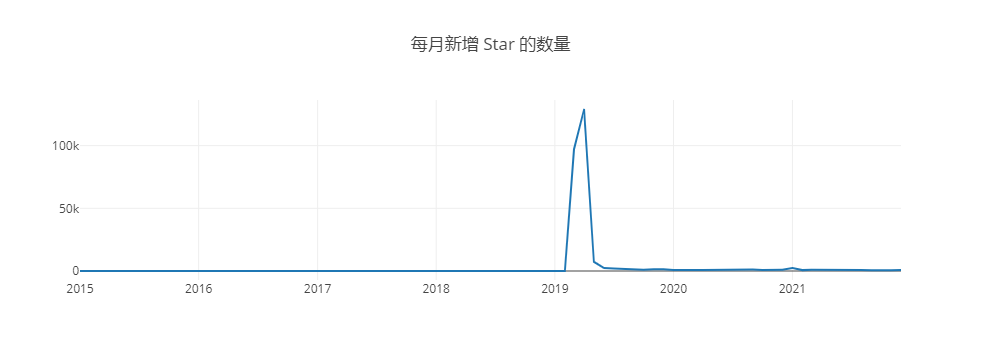

In [25]:
openDigger.render.plotly(
    [
        {x: year_month_axis, y: stars_per_month, mode: 'scatter', name: 'star 数量'}
    ],
    {
        title: '每月新增 Star 的数量'
    }
)

In [26]:
//1 每月fork增加的数量
var forks_per_month = [];
forks_per_month.length = months_amount;

for(let year = start_year; year <= end_year; year++)
{
    for(let month = start_month; month <= end_month; month++)
    {
        query
        (    
            `
            SELECT
                count(*) as forks
            FROM
                github_log.events
            WHERE
                    repo_id = ${repo_id}
                and type = 'ForkEvent'
                and toYear(created_at) = ${year}
                and toMonth(created_at) = ${month}
            `
        )
        .then
        (
            res =>
            {
                forks_per_month[(year - start_year) * 12 + month - 1] = res[0].forks;
            }
        );
    }
}

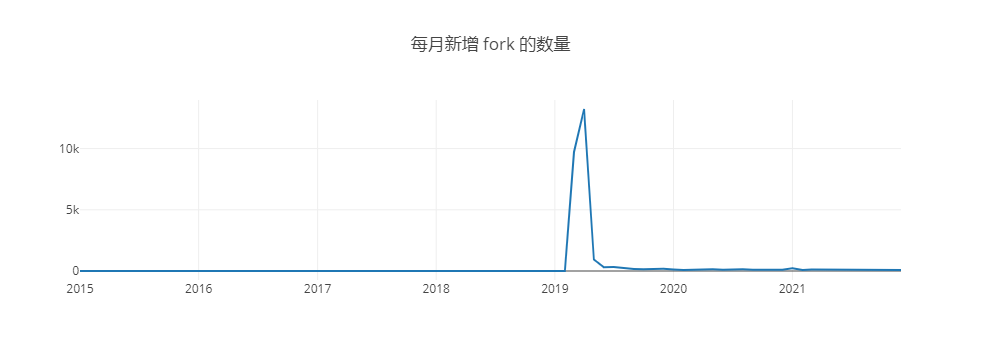

In [27]:
openDigger.render.plotly(
    [
        {x: year_month_axis, y: forks_per_month, mode: 'scatter', name: 'fork 数量'}
    ],
    {
        title: '每月新增 fork 的数量'
    }
)

In [30]:
//1 每月star和fork新增数量表格
var table_stars_forks = []

for(let index = 0; index < year_month_axis.length; index++)
{
    table_stars_forks.push(
        {'year_month': year_month_axis[index],
         'stars': stars_per_month[index],
         'forks': forks_per_month[index]}
    );
}

console.table(
    table_stars_forks.map(
        (data) => {
            return {
                '年-月': data.year_month,
                '新增的star': data.stars,
                '新增的fork': data.forks
            }
        }
    )
)

┌─────────┬───────────┬────────────┬────────────┐
│ (index) │   年-月   │ 新增的star │ 新增的fork │
├─────────┼───────────┼────────────┼────────────┤
│    0    │ '2015-1'  │    '0'     │    '0'     │
│    1    │ '2015-2'  │    '0'     │    '0'     │
│    2    │ '2015-3'  │    '0'     │    '0'     │
│    3    │ '2015-4'  │    '0'     │    '0'     │
│    4    │ '2015-5'  │    '0'     │    '0'     │
│    5    │ '2015-6'  │    '0'     │    '0'     │
│    6    │ '2015-7'  │    '0'     │    '0'     │
│    7    │ '2015-8'  │    '0'     │    '0'     │
│    8    │ '2015-9'  │    '0'     │    '0'     │
│    9    │ '2015-10' │    '0'     │    '0'     │
│   10    │ '2015-11' │    '0'     │    '0'     │
│   11    │ '2015-12' │    '0'     │    '0'     │
│   12    │ '2016-1'  │    '0'     │    '0'     │
│   13    │ '2016-2'  │    '0'     │    '0'     │
│   14    │ '2016-3'  │    '0'     │    '0'     │
│   15    │ '2016-4'  │    '0'     │    '0'     │
│   16    │ '2016-5'  │    '0'     │    '0'     │
│   17  

In [31]:
//2 每月打开issue的数量
var issues_open_per_month = [];
issues_open_per_month.length = months_amount;

for(let year = start_year; year <= end_year; year++)
{
    for(let month = start_month; month <= end_month; month++)
    {
        query
        (    
            `
            SELECT
                count(*) as issues_open
            FROM
                github_log.events
            WHERE
                    repo_id = ${repo_id}
                and type = 'IssuesEvent'
                and (action = 'opened' or action = 'reopened')
                and toYear(created_at) = ${year}
                and toMonth(created_at) = ${month}
            `
        )
        .then
        (
            res =>
            {
                issues_open_per_month[(year - start_year) * 12 + month - 1] = res[0].issues_open;
            }
        );
    }
}

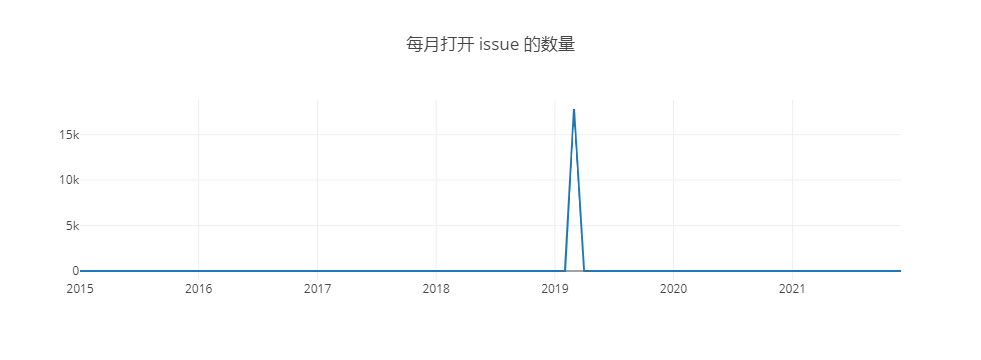

In [32]:
openDigger.render.plotly(
    [
        {x: year_month_axis, y: issues_open_per_month, mode: 'scatter', name: 'issue 数量'}
    ],
    {
        title: '每月打开 issue 的数量'
    }
)

In [33]:
//2 每月关闭issue的数量
var issues_close_per_month = [];
issues_close_per_month.length = months_amount;

for(let year = start_year; year <= end_year; year++)
{
    for(let month = start_month; month <= end_month; month++)
    {
        query
        (    
            `
            SELECT
                count(*) as issues_close
            FROM
                github_log.events
            WHERE
                    repo_id = ${repo_id}
                and type = 'IssuesEvent'
                and action = 'closed'
                and toYear(created_at) = ${year}
                and toMonth(created_at) = ${month}
            `
        )
        .then
        (
            res =>
            {
                issues_close_per_month[(year - start_year) * 12 + month - 1] = res[0].issues_close;
            }
        );
    }
}

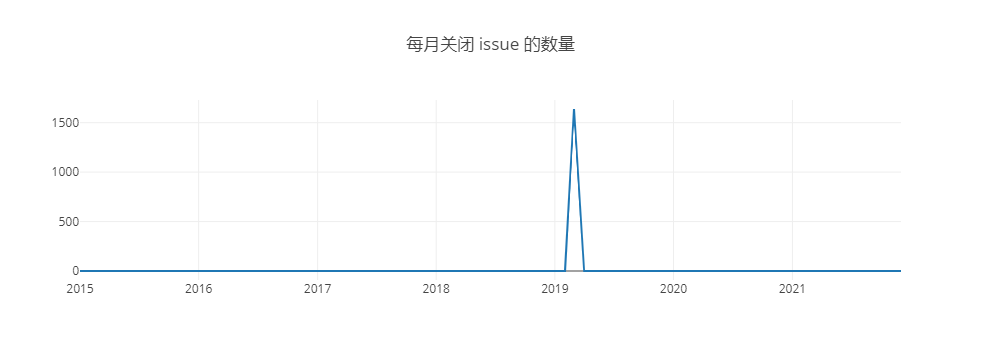

In [34]:
openDigger.render.plotly(
    [
        {x: year_month_axis, y: issues_close_per_month, mode: 'scatter', name: 'issue 数量'}
    ],
    {
        title: '每月关闭 issue 的数量'
    }
)

In [35]:
//2 每月打开、关闭issue数量统计表
var table_issues_open_close = []

for(let index = 0; index < year_month_axis.length; index++)
{
    table_issues_open_close.push(
        {'year_month': year_month_axis[index],
         'open': issues_open_per_month[index],
         'close': issues_close_per_month[index]}
    );
}

console.table(
    table_issues_open_close.map(
        (data) => {
            return {
                '年-月': data.year_month,
                '打开issue': data.open,
                '关闭issue': data.close
            }
        }
    )
)

┌─────────┬───────────┬───────────┬───────────┐
│ (index) │   年-月   │ 打开issue │ 关闭issue │
├─────────┼───────────┼───────────┼───────────┤
│    0    │ '2015-1'  │    '0'    │    '0'    │
│    1    │ '2015-2'  │    '0'    │    '0'    │
│    2    │ '2015-3'  │    '0'    │    '0'    │
│    3    │ '2015-4'  │    '0'    │    '0'    │
│    4    │ '2015-5'  │    '0'    │    '0'    │
│    5    │ '2015-6'  │    '0'    │    '0'    │
│    6    │ '2015-7'  │    '0'    │    '0'    │
│    7    │ '2015-8'  │    '0'    │    '0'    │
│    8    │ '2015-9'  │    '0'    │    '0'    │
│    9    │ '2015-10' │    '0'    │    '0'    │
│   10    │ '2015-11' │    '0'    │    '0'    │
│   11    │ '2015-12' │    '0'    │    '0'    │
│   12    │ '2016-1'  │    '0'    │    '0'    │
│   13    │ '2016-2'  │    '0'    │    '0'    │
│   14    │ '2016-3'  │    '0'    │    '0'    │
│   15    │ '2016-4'  │    '0'    │    '0'    │
│   16    │ '2016-5'  │    '0'    │    '0'    │
│   17    │ '2016-6'  │    '0'    │    '0'    

In [36]:
//3 每月打开 Pull Request 的数量
var pull_request_open_per_month = [];
pull_request_open_per_month.length = months_amount;

for(let year = start_year; year <= end_year; year++)
{
    for(let month = start_month; month <= end_month; month++)
    {
        query
        (
            `
            SELECT
                count(*) pull_request_open
            FROM
                github_log.events
            WHERE
                    repo_id = ${repo_id}
                and type = 'PullRequestEvent'
                and action = 'opened'
                and toYear(created_at) = ${year}
                and toMonth(created_at) = ${month}
            `
        )
        .then
        (
            res => 
            {
                pull_request_open_per_month[(year - start_year) * 12 + month - 1] = res[0].pull_request_open;
            }
        );
    }
}

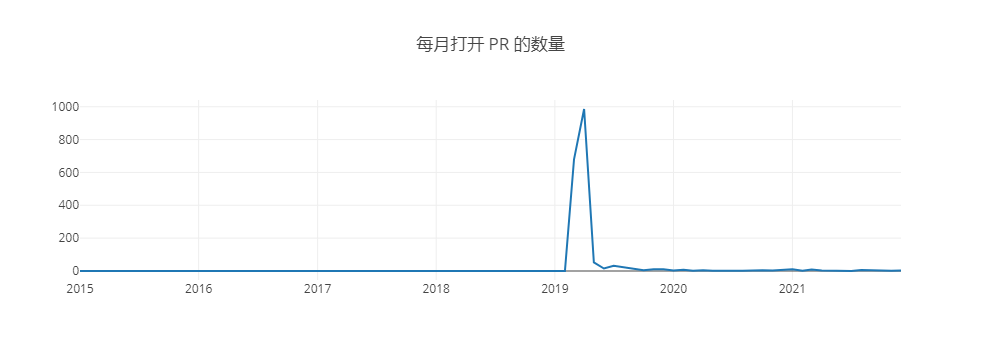

In [37]:
openDigger.render.plotly(
    [
        {x: year_month_axis, y: pull_request_open_per_month, mode: 'scatter', name: 'PR 打开数量'}
    ],
    {
        title: '每月打开 PR 的数量'
    }
)

In [38]:
//3 每月合并 Pull Request 的数量
var pull_request_merged_per_month = [];
pull_request_merged_per_month.length = months_amount;

for(let year = start_year; year <= end_year; year++)
{
    for(let month = start_month; month <= end_month; month++)
    {
        query
        (
            `
            SELECT
                count(*) pull_request_merged
            FROM
                github_log.events
            WHERE
                    repo_id = ${repo_id}
                and type = 'PullRequestEvent'
                and action = 'closed'
                and pull_merged_by_id != 0
                and toYear(created_at) = ${year}
                and toMonth(created_at) = ${month}
            `
        )
        .then
        (
            res => 
            {
                pull_request_merged_per_month[(year - start_year) * 12 + month - 1] = res[0].pull_request_merged;
            }
        );
    }
}

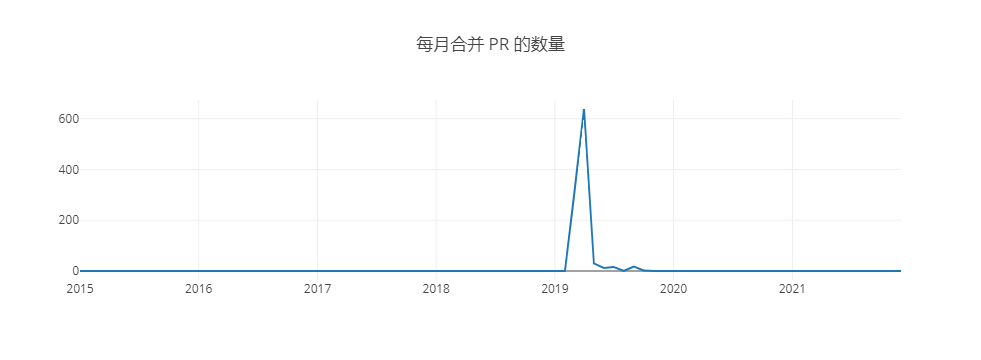

In [39]:
openDigger.render.plotly(
    [
        {x: year_month_axis,
         y: pull_request_merged_per_month,
         mode: 'scatter',
         name: 'PR 合并数量'}
    ],
    {
        title: '每月合并 PR 的数量'
    }
)

In [40]:
//3 每月打开、合并pull request的数量统计表
var table_prs_open_merge = []

for(let index = 0; index < year_month_axis.length; index++)
{
    table_prs_open_merge.push(
        {'year_month': year_month_axis[index],
         'open': pull_request_open_per_month[index],
         'merge': pull_request_merged_per_month[index]}
    );
}

console.table(
    table_prs_open_merge.map(
        (data) => {
            return {
                '年-月': data.year_month,
                '打开Pull Request': data.open,
                '合并Pull Request': data.merge
            }
        }
    )
)

┌─────────┬───────────┬──────────────────┬──────────────────┐
│ (index) │   年-月   │ 打开Pull Request │ 合并Pull Request │
├─────────┼───────────┼──────────────────┼──────────────────┤
│    0    │ '2015-1'  │       '0'        │       '0'        │
│    1    │ '2015-2'  │       '0'        │       '0'        │
│    2    │ '2015-3'  │       '0'        │       '0'        │
│    3    │ '2015-4'  │       '0'        │       '0'        │
│    4    │ '2015-5'  │       '0'        │       '0'        │
│    5    │ '2015-6'  │       '0'        │       '0'        │
│    6    │ '2015-7'  │       '0'        │       '0'        │
│    7    │ '2015-8'  │       '0'        │       '0'        │
│    8    │ '2015-9'  │       '0'        │       '0'        │
│    9    │ '2015-10' │       '0'        │       '0'        │
│   10    │ '2015-11' │       '0'        │       '0'        │
│   11    │ '2015-12' │       '0'        │       '0'        │
│   12    │ '2016-1'  │       '0'        │       '0'        │
│   13    │ '2

In [41]:
//4  每月在仓库中活跃的不同开发者数量
var active_developer_per_month = [];
active_developer_per_month.length = months_amount;

for(let year = start_year; year <= end_year; year++)
{
    for(let month = start_month; month <= end_month; month++)
    {
        query
        (
            `
            SELECT
                COUNT(DISTINCT actor_id) as active_developer_num
            FROM 
                github_log.events
            WHERE 
                    repo_id = ${repo_id}
                and toYear(created_at) = ${year}
                and toMonth(created_at) = ${month}
            `
        )
        .then
        (
            res => 
            {
                active_developer_per_month[(year - start_year) * 12 + month - 1] = res[0].active_developer_num;
            }
        );
    }
}

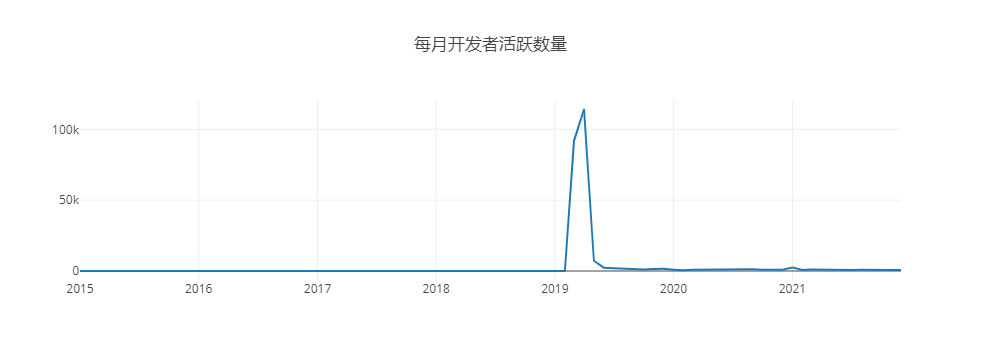

In [42]:
openDigger.render.plotly(
    [
        {x: year_month_axis,
         y: active_developer_per_month,
         mode: 'scatter',
         name: '开发者活跃数量'}
    ],
    {
        title: '每月开发者活跃数量'
    }
)

In [43]:
//4 每月活跃用户的统计表
var table_active_developer = []

for(let index = 0; index < year_month_axis.length; index++)
{
    table_active_developer.push(
        {'year_month': year_month_axis[index],
         'active_developer': active_developer_per_month[index]}
    );
}

console.table(
    table_active_developer.map(
        (data) => {
            return {
                '年-月': data.year_month,
                '活跃人数': data.active_developer
            }
        }
    )
)

┌─────────┬───────────┬──────────┐
│ (index) │   年-月   │ 活跃人数 │
├─────────┼───────────┼──────────┤
│    0    │ '2015-1'  │   '0'    │
│    1    │ '2015-2'  │   '0'    │
│    2    │ '2015-3'  │   '0'    │
│    3    │ '2015-4'  │   '0'    │
│    4    │ '2015-5'  │   '0'    │
│    5    │ '2015-6'  │   '0'    │
│    6    │ '2015-7'  │   '0'    │
│    7    │ '2015-8'  │   '0'    │
│    8    │ '2015-9'  │   '0'    │
│    9    │ '2015-10' │   '0'    │
│   10    │ '2015-11' │   '0'    │
│   11    │ '2015-12' │   '0'    │
│   12    │ '2016-1'  │   '0'    │
│   13    │ '2016-2'  │   '0'    │
│   14    │ '2016-3'  │   '0'    │
│   15    │ '2016-4'  │   '0'    │
│   16    │ '2016-5'  │   '0'    │
│   17    │ '2016-6'  │   '0'    │
│   18    │ '2016-7'  │   '0'    │
│   19    │ '2016-8'  │   '0'    │
│   20    │ '2016-9'  │   '0'    │
│   21    │ '2016-10' │   '0'    │
│   22    │ '2016-11' │   '0'    │
│   23    │ '2016-12' │   '0'    │
│   24    │ '2017-1'  │   '0'    │
│   25    │ '2017-2'  │   

In [45]:
//5 issue从打开到关闭的平均时长和中位数时长（单位：天）
query
(
    `
    SELECT
        AVG(opened_time) as avgOpenTime,
        quantile(0.5)(opened_time) as mediumOpenTime
    FROM 
        (
        SELECT repo_id, type, action, (toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at)) as opened_time FROM github_log.events
        )
    WHERE 
            repo_id = ${repo_id}
        and type = 'IssuesEvent'
        and action = 'closed'
    `
)
.then
(
    res => 
    {
        console.log(res);
    }
);

[ { avgOpenTime: 0.10006101281269067, mediumOpenTime: 0 } ]


In [46]:
//6 PR从打开到合并的平均时长和中位数时长（单位：天）
query
(
    `
    SELECT
        AVG(opened_time) as avgOpeneTime,
        quantile(0.5)(opened_time) as mediumOpenTime
    FROM
        (
            SELECT
                toRelativeDayNum(max(created_at)) - toRelativeDayNum(min(created_at)) as opened_time
            FROM 
                (
                SELECT repo_id, type, created_at, issue_id FROM github_log.events
                )
            WHERE 
                    repo_id = ${repo_id}
                and type = 'PullRequestEvent'
            GROUP BY 
                issue_id
            HAVING
                COUNT(*) = 2
        )
    `
)
.then
(
    res => 
    {
        console.log(res);
    }
);

[ { avgOpeneTime: 23.281871974179666, mediumOpenTime: 0 } ]


In [47]:
// 7 issue和PR从打开第一次有人回复（非本人回复）的平均时长和中位数时长（单位：天）
query
(
    `
    SELECT
        AVG(time) as avg_time,
        quantile(0.5)(time) as medium_time,
        COUNT(*) count
    FROM
        ((
            SELECT
                issue_id,
                MIN(toRelativeDayNum(issue_comment_created_at) - toRelativeDayNum(issue_created_at)) as time
            FROM 
                (
                SELECT repo_id, type, action, issue_id, issue_created_at, issue_comment_created_at, issue_comment_author_id, issue_author_id FROM github_log.events
                )
            WHERE 
                    repo_id = ${repo_id}
                and type = 'IssueCommentEvent'
                and action = 'created'
                and issue_comment_author_id != issue_author_id
            GROUP BY
                issue_id
        )
        UNION ALL
        (
            SELECT
                issue_id,
                MIN(toRelativeDayNum(created_at) - toRelativeDayNum(issue_created_at)) as time
            FROM 
                (
                SELECT repo_id, type, action, issue_id, issue_created_at, created_at, issue_author_login, pull_requested_reviewer_login FROM github_log.events
                )
            WHERE 
                    repo_id = ${repo_id}
                and type = 'PullRequestReviewEvent'
                and action = 'created'
                and issue_author_login != pull_requested_reviewer_login
            GROUP BY
                issue_id
        ))
    `
)
.then
(
    res => 
    {
        console.log(res);
    }
);

[ { avg_time: 0.3322867608581894, medium_time: 0, count: '5733' } ]
